In [1]:


import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

# %system nvidia-smi
#%system rocm-smi



py 3.7.3
tf 2.1.0
keras 2.2.4-tf
mem 15475.94140625
cpu 4


/home/roman/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Variables

epochs = 100
batch_size = 150
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 120
seed = random.randint(1, 1000)

data_dir = "/home/roman/!!!Python/Neyroseti/6/DZ6/2-Dog-Test-Keras/kaggle/input/Images/"
annotations_dir = "/home/roman/!!!Python/Neyroseti/6/DZ6/2-Dog-Test-Keras/kaggle/input/Annotation/"
cropped_dir = "/home/roman/!!!Python/Neyroseti/6/DZ6/2-Dog-Test-Keras/kaggle/working/cropped/"

In [3]:
# Crop images using provided annotations
# look at cropping_images.py

In [4]:
# Keras image data readers

datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 15712 images belonging to 120 classes.
Found 3866 images belonging to 120 classes.


/home/roman/!!!Python/Neyroseti/6/DZ6/2-Dog-Test-Keras/kaggle/working/cropped/n02099712-Labrador_retriever/n02099712_4133.jpg


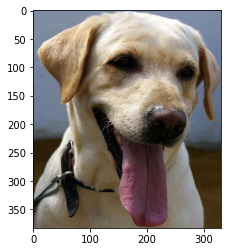

In [5]:
# Sample image

img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [6]:
# Keras callbacks

checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

#https://github.com/keras-team/keras/issues/3358
tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [9]:
# Define new top layers and compile model

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=learning_rate)
# optimizer = RMSprop(lr=learning_rate)

loss = "categorical_crossentropy"
# loss = "kullback_leibler_divergence"

for layer in model.layers:
    layer.trainable = True
# for layer in model.layers[-2:]:
#     layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

9412608/9406464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________

In [10]:
# Fit model

params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 105 steps, validate for 26 steps
Learning rate:  1e-04
Epoch 1/100
104/105 [============================>.] - ETA: 30s - loss: 2.2757 - accuracy: 0.4751 
Epoch 00001: val_accuracy improved from -inf to 0.61718, saving model to dog_breed_classifier.h5
105/105 [==============================] - 3407s 32s/step - loss: 2.2644 - accuracy: 0.4773 - val_loss: 1.7087 - val_accuracy: 0.6172
Learning rate:  1e-04
Epoch 2/100
104/105 [============================>.] - ETA: 29s - loss: 0.7157 - accuracy: 0.7991
Epoch 00002: val_accuracy improved from 0.61718 to 0.66632, saving model to dog_breed_classifier.h5
105/105 [==============================] - 3329s 32s/step - loss: 0.7142 - accuracy: 0.7998 - val_loss: 1.1969 - val_accuracy: 0.6663
Learning rate:  1e-04
Epoch 3/100
104/105 [============================>.] - ETA: 30s - loss: 0.4441 - accuracy: 0.8769 
Epoc

105/105 [==============================] - 3169s 30s/step - loss: 0.0057 - accuracy: 0.9996 - val_loss: 0.7516 - val_accuracy: 0.8112
Learning rate:  3.1622774e-05
Epoch 24/100
 23/105 [=====>........................] - ETA: 40:22 - loss: 0.0047 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
# Training and test loss/accuracy graphs

plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

In [ ]:
# Sample prediction

# Randomly test an image from the test set

# model.load_weights('dog_breed_classifier.h5')

imageno=np.random.random_integers(low=0, high=test_generator.samples)

name = test_generator.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test_generator.filepaths[imageno]).resize((targetx, targety))
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

In [ ]:
# Classification report

test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

In [ ]:
# Confusion matrix

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

In [ ]:
# shutil.rmtree(cropped_dir)